In [1]:
import numpy as np
import wisps
import wisps.simulations as wispsim
import pandas as pd
import splat
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from scipy.interpolate import interp1d
import numba
from tqdm import tqdm
import splat.empirical as spem
import wisps.simulations.effective_numbers as ef 
import seaborn as sns
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import Normalize
import matplotlib as mpl
import splat.empirical as spe

%matplotlib inline

In [13]:
pnts=wisps.OBSERVED_POINTINGS

In [158]:
def bin_by_spt_bin(sp_types, number):
    ranges=[[17, 20], [20, 25], [25, 30], [30, 35], [35, 40]]
    numbers=[]
    for r in ranges:
        idx= np.logical_and((r[0]<=sp_types), (r[1]>sp_types))
        numbers.append(np.nansum(number[idx]))
    return numbers

def iswithin_mag_limits(mags, pnt):
    #mgs is a dictionary
    flags=[]
    for k in pnt.mag_limits.keys():
        if k =='F110' and pnt.survey =='hst3d':
            flags.append(True)
        else:
            flags.append(mags[k] < pnt.mag_limits[k])
    return np.logical_or.reduce(flags)


In [159]:
sgrid=wispsim.SPGRID

In [16]:
cands=pd.read_hdf(wisps.OUTPUT_FILES+'/true_spectra_cands.hdf', key='with_indices')

In [25]:
pnt_names=[x.name for x in pnts]

In [29]:
pnt_names.index('par1')

149

In [54]:
pnts[0].survey

'hst3d'

In [63]:
def get_pointing(grism_id):
    if grism_id.startswith('par'):
        pntname=grism_id.lower().split('-')[0]
    else:
        pntname=grism_id.lower().split('-g141')[0]
    loc=pnt_names.index(pntname)
    return np.array(pnts)[loc]
    

def get_mags(row):
    return pd.Series(row.spectra.mags)

In [64]:
mags_df=cands.apply(get_mags, axis=1)
tab=wisps.Annotator.reformat_table(cands.join(mags_df))
tab['pnt']=tab['grism_id'].apply(get_pointing)

In [166]:
obsmgs=tab[['F140W', 'F110W', 'F160W']].rename(columns={"F110W": "F110", 
                                                                    "F140W": "F140",
                                                                    "F160W": "F160"}).to_dict('records')
flags=[iswithin_mag_limits(x, y) for x, y in zip(obsmgs, tab.pnt.values)]

cdf_to_use=tab[flags]
nobs=wisps.custom_histogram(cdf_to_use.spt.apply(wisps.make_spt_number), sgrid, 1)

In [67]:
spgrid2=['M7-L0', 'L0-L5', 'L5-T0', 'T0-T5', 'T5-Y0']
cnorm=Normalize(wispsim.HS[0], wispsim.HS[-1])

In [167]:
def compute_simulated_numbers(hidx, model='saumon', selection='prob'):
    #an index in accordance with the scale height
    data=ef.simulation_outputs()[model]
    sim_data=wispsim.simulate_spts(name=model)
    
    simdf=pd.DataFrame()
    nanidx=np.isnan(sim_data['spts'].flatten())
    simdf['spt']=wisps.drop_nan(sim_data['spts'].flatten())
    simdf['teffs']=(sim_data['teffs'].flatten())[~nanidx]
    simdf['slprob']=data['sl_prob'][hidx]
    simdf['snr']=data['snrjs'][hidx]
    simdf['appF140']=data['appf140s'][hidx]
    simdf['appF110']=data['appf110s'][hidx]
    simdf['appF160']=data['appf160s'][hidx]
    simdf['pntname']=data['pointing'][hidx]
    simdf['pnt']=simdf.pntname.apply(lambda x: np.array(pnts)[pnt_names.index(x)])
    
    simmgs=simdf[['appF140', 'appF110', 'appF160']].rename(columns={"appF110": "F110", 
                                                                    "appF140": "F140",
                                                                    "appF160": "F160"}).to_dict('records')
    flags=[iswithin_mag_limits(x, y) for x, y in zip(simmgs,  simdf.pnt.values)]
    
    
    cutdf=(simdf[flags]).reset_index(drop=True)
    NORM = 0.63*(10**-3)/ len(cutdf.teffs[np.logical_and(cutdf.teffs>=1650, cutdf.teffs <=1800)])
    
    NSIM=dict(zip(wispsim.SPGRID,np.zeros(len(wispsim.SPGRID))))
    #rounded spectral type
    cutdf['spt_r']=cutdf.spt.apply(np.round)
    for g in cutdf.groupby('spt_r'):
        NSIM[g[0]]=np.nansum((g[1]).slprob*NORM)
        
    return NSIM

In [168]:
volumes=[]
for pnt in pnts:
    vs=[]
    for h in wispsim.HS:
        vsx=[]
        for g in wispsim.SPGRID:
            vsx.append((pnt.volumes[h])[g])
        vs.append(vsx)
    volumes.append(vs)
volumes=np.array(volumes)

In [70]:
VOLUMES=np.nansum(volumes, axis=0)*4.1*(u.arcmin**2).to(u.radian**2)

In [71]:
import seaborn as sns
#flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(sns.color_palette("PuOr", len(wispsim.HS)))




0it [00:00, ?it/s]


1it [03:32, 212.16s/it]


2it [06:37, 204.20s/it]


3it [09:48, 200.22s/it]


4it [12:36, 190.62s/it]


5it [15:08, 179.01s/it]


6it [26:59, 338.39s/it]


7it [30:24, 260.60s/it]


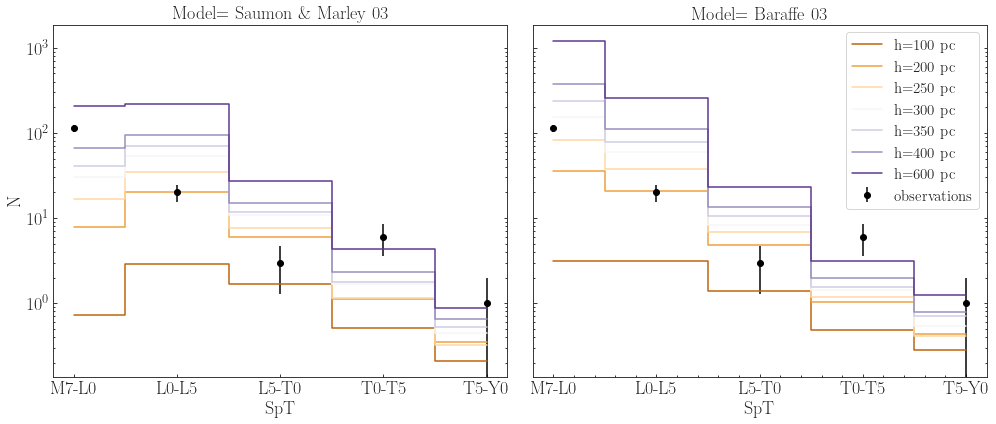

In [169]:
fig, (ax, ax1)=plt.subplots(figsize=(14,6), ncols=2, sharey=True)


nexpct=[]
for idx, h in tqdm(enumerate(wispsim.HS)):
    
    nsimulated_saumon=compute_simulated_numbers(idx)
    nsimulated_baraffe=compute_simulated_numbers(idx, model='baraffe03' )
    
    ns_bar=[]
    ns_saumon=[]
    for s in wispsim.SPGRID:
            ns_bar.append(nsimulated_baraffe[s])
            ns_saumon.append(nsimulated_saumon[s])
    
        
    ns_bar=np.array(ns_bar)
    ns_saumon=np.array(ns_saumon)
    
    ax1.step(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns_bar*VOLUMES[idx]), 
                 where='mid', label='h={} pc'.format(wispsim.HS[idx]))
    
    ax.step(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns_saumon*VOLUMES[idx]),
            where='mid', label='h={} pc'.format(wispsim.HS[idx]))
    
    nexpct.append( bin_by_spt_bin(wispsim.SPGRID,ns_bar*VOLUMES[idx]))
    



ax.set_yscale('log')
ax1.set_yscale('log')

y2=bin_by_spt_bin(wispsim.SPGRID,nobs)
dy2=np.sqrt(y2)
ax1.errorbar(spgrid2,y2, yerr=dy2,
            label='observations',fmt='o', color='k')
ax.errorbar(spgrid2,y2, yerr=dy2,
            label='observations',fmt='o', color='k')

ax1.set_xlabel('SpT',fontsize=18)

ax.set_xlabel('SpT',fontsize=18)
ax.set_ylabel('N',fontsize=18)

ax.set_title('Model= Saumon \& Marley 03', fontsize=18)
ax1.set_title('Model= Baraffe 03', fontsize=18)
ax1.legend(fontsize=15, loc=(1))

plt.minorticks_on()

plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/oberved_numbers.pdf', bbox_inches='tight')


In [17]:
sim_df=pd.DataFrame()

In [18]:
nexpct=np.round(nexpct)

In [19]:
sim_df['h']=wispsim.HS
sim_df['M7-L0']=nexpct[:,0]
sim_df['L0-L5']=nexpct[:,1]
sim_df['L5-T0']=nexpct[:, 2]
sim_df['T0-T5']=nexpct[:,3]
sim_df['T5-Y0']=nexpct[:, 4]

In [20]:
sim_df.to_latex()

'\\begin{tabular}{lrrrrrr}\n\\toprule\n{} &    h &   M7-L0 &  L0-L5 &  L5-T0 &  T0-T5 &  T5-Y0 \\\\\n\\midrule\n0 &  100 &     5.0 &    3.0 &    1.0 &    0.0 &    0.0 \\\\\n1 &  200 &    64.0 &   24.0 &    3.0 &    1.0 &    0.0 \\\\\n2 &  250 &   133.0 &   40.0 &    4.0 &    1.0 &    0.0 \\\\\n3 &  300 &   211.0 &   50.0 &    5.0 &    1.0 &    0.0 \\\\\n4 &  350 &   288.0 &   66.0 &    6.0 &    1.0 &    1.0 \\\\\n5 &  400 &   445.0 &   77.0 &    7.0 &    1.0 &    0.0 \\\\\n6 &  600 &  1336.0 &  167.0 &    8.0 &    2.0 &    1.0 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [21]:
sim_df.columns

Index(['h', 'M7-L0', 'L0-L5', 'L5-T0', 'T0-T5', 'T5-Y0'], dtype='object')

In [22]:
y2

[145, 26, 3, 12, 2]